# 1. Setup


In [20]:
!pip -q install statsmodels prophet

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

#Global plot style
plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.grid"] = False
plt.rcParams["figure.dpi"] = 120

#Create folders
os.makedirs("reports/figures", exist_ok=True)
os.makedirs("data", exist_ok=True)

#Reproducibility
np.random.seed(42)



# 2. Data loading

In [21]:
CSV_PATH = "data/sample_timeseries.csv"

def make_synthetic_series(n=730, start="2023-01-01", noise_sd=6.0, weekly_amp=8.0, trend_total=60.0):
    """Create a daily series with trend + weekly + yearly seasonality + noise."""
    dates = pd.date_range(start=start, periods=n, freq="D")
    t = np.arange(n)

    #Components
    trend = trend_total * (t / (n - 1))                      # linear trend
    weekly = weekly_amp * np.sin(2 * np.pi * (dates.dayofweek / 7.0))
    yearly = 5.0 * np.sin(2 * np.pi * (dates.dayofyear / 365.25))
    noise = np.random.normal(0, noise_sd, size=n)

    y = 100 + trend + weekly + yearly + noise
    df = pd.DataFrame({"Date": dates, "Value": y})
    return df

if os.path.exists(CSV_PATH):
    df = pd.read_csv(CSV_PATH, parse_dates=["Date"])
    df = df.sort_values("Date").reset_index(drop=True)
else:
    df = make_synthetic_series()
    df.to_csv(CSV_PATH, index=False)

df.head()


,Date,Value
0,2023-01-01,96.811641
1,2023-01-02,99.424709
2,2023-01-03,110.563314
3,2023-01-04,117.528293
4,2023-01-05,102.824898


# 3. Exploratory data analysis

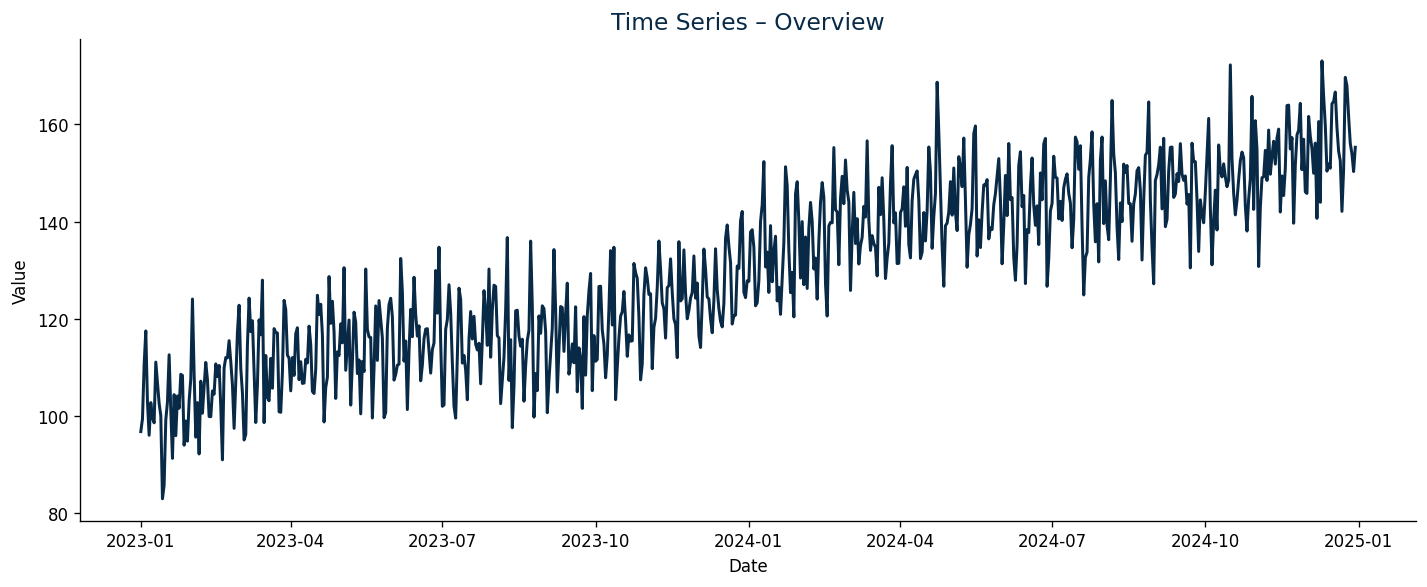

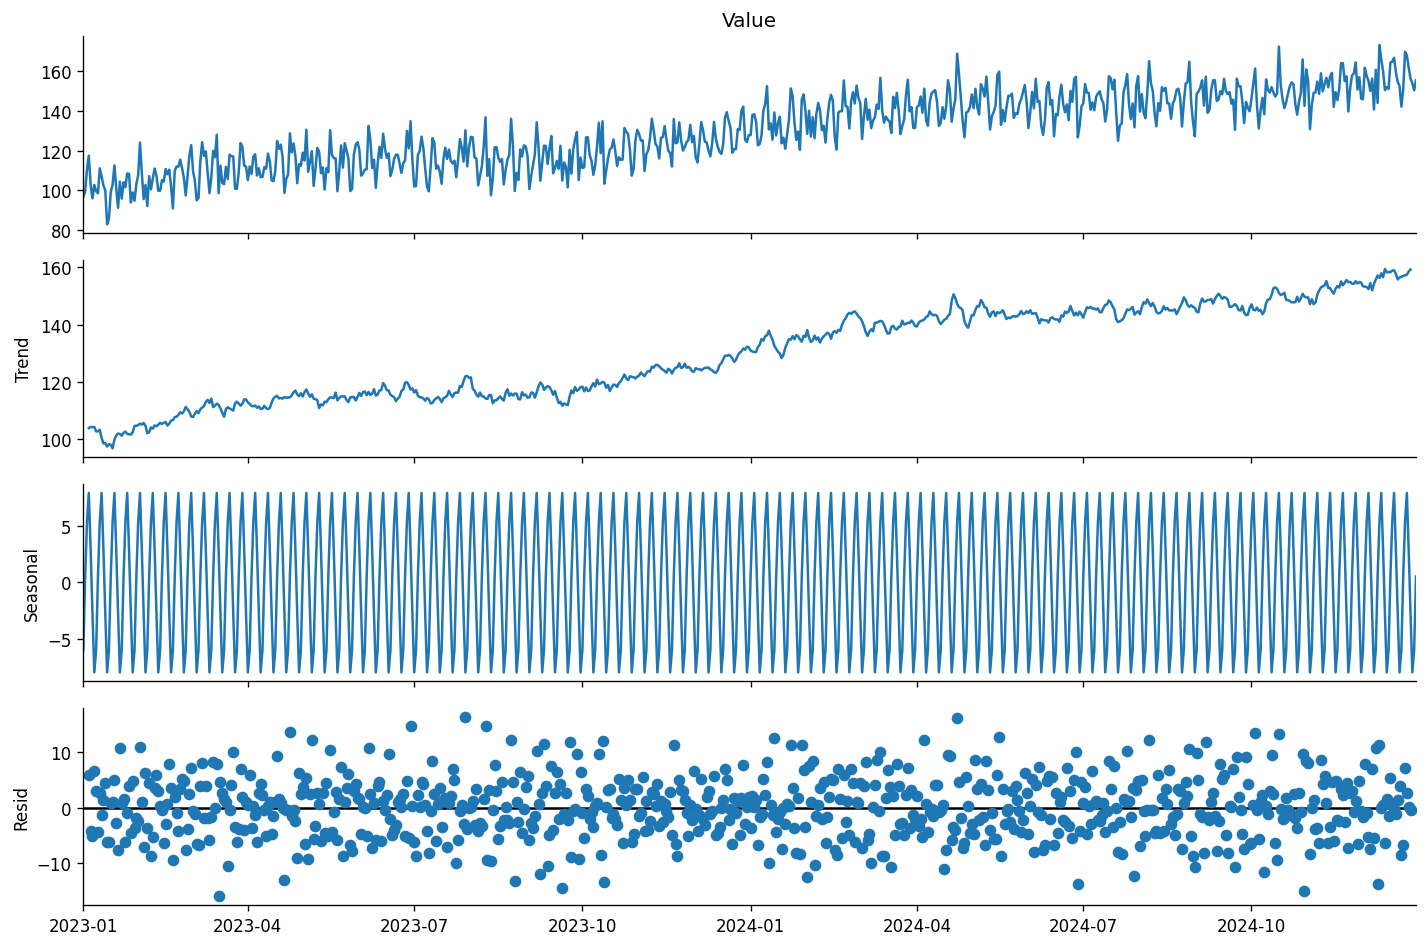

In [22]:
#Overview plot
plt.plot(df["Date"], df["Value"], color="#092a47", linewidth=1.8)
plt.title("Time Series – Overview", fontsize=14, color="#092a47")
plt.xlabel("Date"); plt.ylabel("Value")
plt.tight_layout()
plt.savefig("reports/figures/ts_overview.png", bbox_inches="tight", dpi=300)
plt.show()

#Seasonal decomposition (additive) – requires PeriodIndex or DatetimeIndex freq
ts = df.set_index("Date")["Value"].asfreq("D").interpolate()
decomp = seasonal_decompose(ts, model="additive", period=7)  # weekly pattern

fig = decomp.plot()
fig.set_size_inches(12, 8)
plt.tight_layout()
plt.savefig("ts_decomposition.png", bbox_inches="tight", dpi=300)
plt.show()


# 4. Stationarity check + ACF/PACF

ADF test p-value: 0.8263  (lower is better for stationarity)


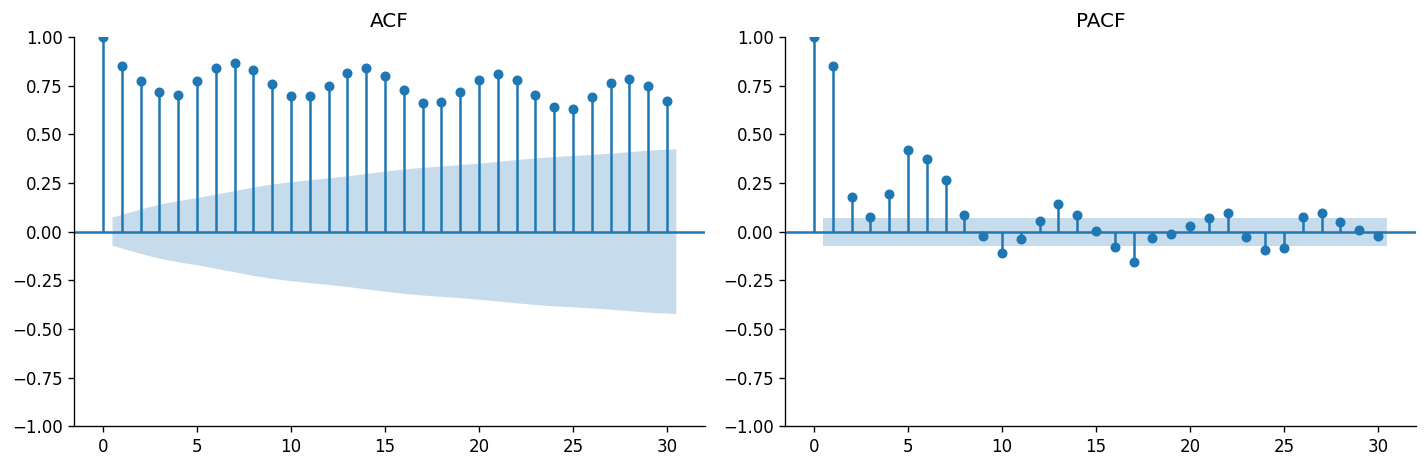

In [23]:
pval = adfuller(ts.dropna())[1]
print(f"ADF test p-value: {pval:.4f}  (lower is better for stationarity)")

fig, ax = plt.subplots(1, 2, figsize=(12,4))
plot_acf(ts, lags=30, ax=ax[0])
plot_pacf(ts, lags=30, ax=ax[1], method="ywm")
ax[0].set_title("ACF"); ax[1].set_title("PACF")
plt.tight_layout()
plt.savefig("acf_pacf.png", bbox_inches="tight", dpi=300)
plt.show()


# 5. Train/Validation split + baseline models

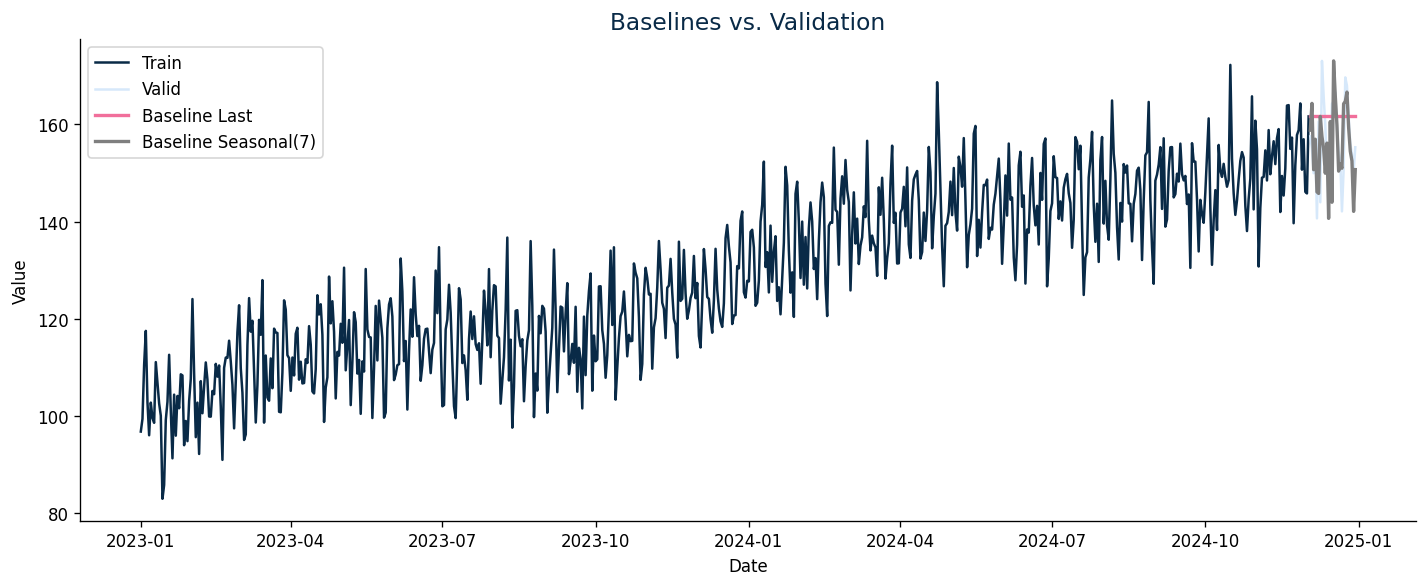

[('Naive-Last', 7.919299928739465, np.float64(5.194929300620489)),
 ('Naive-Seasonal(7)', 6.934110640083209, np.float64(4.440134724031632))]

In [24]:
series = ts.copy()
horizon = 28  #4 weeks hold-out
train = series.iloc[:-horizon]
valid = series.iloc[-horizon:]

#Baseline 1: Last value (naive)
baseline_last = pd.Series(train.iloc[-1], index=valid.index)

#Baseline 2: Seasonal naive (lag 7)
baseline_seasonal = series.shift(7).iloc[-horizon:]

def mape(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-6, None))) * 100

metrics = []

mae_last = mean_absolute_error(valid, baseline_last)
mape_last = mape(valid, baseline_last)
metrics.append(("Naive-Last", mae_last, mape_last))

mae_seas = mean_absolute_error(valid, baseline_seasonal)
mape_seas = mape(valid, baseline_seasonal)
metrics.append(("Naive-Seasonal(7)", mae_seas, mape_seas))

# Plot baselines
plt.plot(train.index, train, label="Train", color="#092a47")
plt.plot(valid.index, valid, label="Valid", color="#d6e8fa")
plt.plot(valid.index, baseline_last, label="Baseline Last", color="#f16f9b", linewidth=2)
plt.plot(valid.index, baseline_seasonal, label="Baseline Seasonal(7)", color="#7f7f7f", linewidth=2)
plt.title("Baselines vs. Validation", fontsize=14, color="#092a47")
plt.xlabel("Date"); plt.ylabel("Value"); plt.legend()
plt.tight_layout()
plt.savefig("baselines.png", bbox_inches="tight", dpi=300)
plt.show()

metrics


# 6. SARIMA (with weekly seasonality)

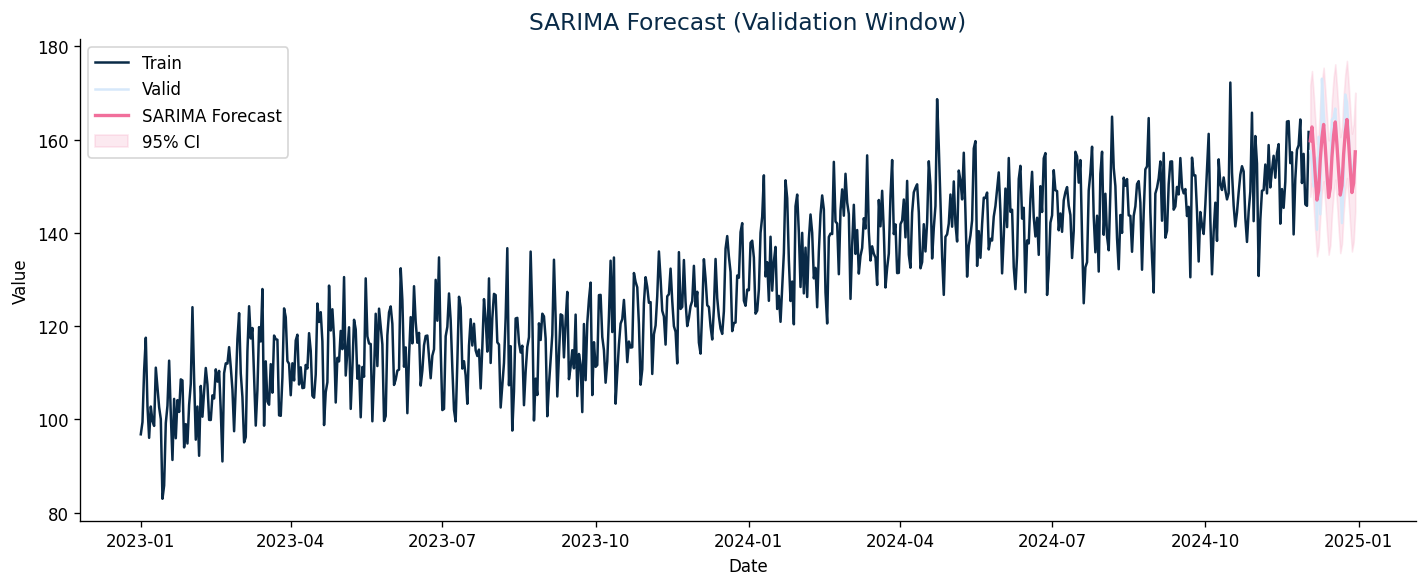

In [25]:
#A robust, small-parameter choice for daily data with weekly seasonality:
#order=(1,1,1), seasonal_order=(1,1,1,7)

sarima = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,7), enforce_stationarity=False, enforce_invertibility=False)
sarima_res = sarima.fit(disp=False)

sarima_fc = sarima_res.get_forecast(steps=horizon)
sarima_pred = sarima_fc.predicted_mean
sarima_ci = sarima_fc.conf_int()

mae_sarima = mean_absolute_error(valid, sarima_pred)
mape_sarima = mape(valid, sarima_pred)
metrics.append(("SARIMA(1,1,1)(1,1,1,7)", mae_sarima, mape_sarima))

# Plot SARIMA forecast
plt.plot(train.index, train, label="Train", color="#092a47")
plt.plot(valid.index, valid, label="Valid", color="#d6e8fa")
plt.plot(valid.index, sarima_pred, label="SARIMA Forecast", color="#f16f9b", linewidth=2)
plt.fill_between(valid.index, sarima_ci.iloc[:,0], sarima_ci.iloc[:,1], color="#f16f9b", alpha=0.15, label="95% CI")
plt.title("SARIMA Forecast (Validation Window)", fontsize=14, color="#092a47")
plt.xlabel("Date"); plt.ylabel("Value"); plt.legend()
plt.tight_layout()
plt.savefig("sarima_forecast.png", bbox_inches="tight", dpi=300)
plt.show()


# 7. Prophet (weekly + yearly seasonality)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpvf80mh0g/wka2uayd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvf80mh0g/gxs0f6zh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80372', 'data', 'file=/tmp/tmpvf80mh0g/wka2uayd.json', 'init=/tmp/tmpvf80mh0g/gxs0f6zh.json', 'output', 'file=/tmp/tmpvf80mh0g/prophet_modelcqxs5v3v/prophet_model-20251015203455.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:34:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:34:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


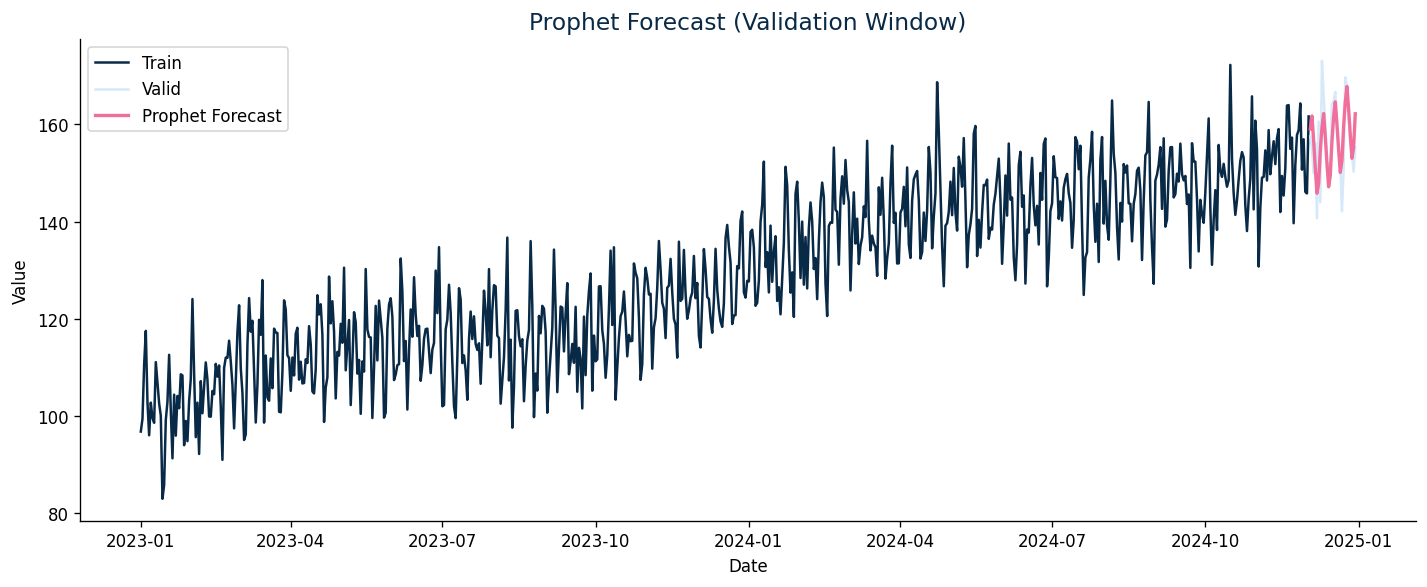

In [26]:
from prophet import Prophet

df_prophet = series.reset_index().rename(columns={"Date":"ds", "Value":"y"})
train_p = df_prophet.iloc[:-horizon].copy()
valid_p = df_prophet.iloc[-horizon:].copy()

m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)
m.fit(train_p)

future = m.make_future_dataframe(periods=horizon, freq="D")
fcst = m.predict(future)

#Align predictions with validation period
prophet_pred = fcst.set_index("ds").loc[valid_p["ds"], "yhat"]

mae_prophet = mean_absolute_error(valid_p["y"], prophet_pred)
mape_prophet = mape(valid_p["y"], prophet_pred)
metrics.append(("Prophet(weekly+yearly)", mae_prophet, mape_prophet))

#Plot Prophet forecast on validation window
plt.plot(train_p["ds"], train_p["y"], label="Train", color="#092a47")
plt.plot(valid_p["ds"], valid_p["y"], label="Valid", color="#d6e8fa")
plt.plot(valid_p["ds"], prophet_pred, label="Prophet Forecast", color="#f16f9b", linewidth=2)
plt.title("Prophet Forecast (Validation Window)", fontsize=14, color="#092a47")
plt.xlabel("Date"); plt.ylabel("Value"); plt.legend()
plt.tight_layout()
plt.savefig("prophet_forecast.png", bbox_inches="tight", dpi=300)
plt.show()


# 8. Metric comparison (MAE / MAPE)

In [27]:
metrics_df = pd.DataFrame(metrics, columns=["Model", "MAE", "MAPE(%)"]).sort_values("MAE")
display(metrics_df)

#Save to repo for quick glance
metrics_df.to_csv("metrics.csv", index=False)


,Model,MAE,MAPE(%)
3,Prophet(weekly+yearly),4.765970,3.064899
2,"SARIMA(1,1,1)(1,1,1,7)",4.827194,3.092368
1,Naive-Seasonal(7),6.934111,4.440135
0,Naive-Last,7.919300,5.194929


# 9. Conclusions

In [28]:
best = metrics_df.iloc[0]
print(
    "Summary:\n"
    f"- Baselines provide a reference: Naive-Last (MAE={metrics_df.loc[metrics_df.Model=='Naive-Last','MAE'].values[0]:.2f}), "
    f"Seasonal-Naive (MAE={metrics_df.loc[metrics_df.Model=='Naive-Seasonal(7)','MAE'].values[0]:.2f}).\n"
    f"- SARIMA validation MAE={mae_sarima:.2f}, MAPE={mape_sarima:.2f}%.\n"
    f"- Prophet validation MAE={mae_prophet:.2f}, MAPE={mape_prophet:.2f}%.\n"
    f"=> Best model on this split: {best['Model']} (MAE={best['MAE']:.2f}, MAPE={best['MAPE(%)']:.2f}%)."
)


Summary:
- Baselines provide a reference: Naive-Last (MAE=7.92), Seasonal-Naive (MAE=6.93).
- SARIMA validation MAE=4.83, MAPE=3.09%.
- Prophet validation MAE=4.77, MAPE=3.06%.
=> Best model on this split: Prophet(weekly+yearly) (MAE=4.77, MAPE=3.06%).
